# Fantasy Football Roster Predictions

## Problem
Use the data provided from past NFL seasons to determine if a machine learning model can help predict and create a winning fantasy football team. Can a model predict a fantasy football roster that can win a fantasy football league?  Every year thousands of fans come together to create their "Dream Team" for a chance to win a cash prize. 

## Data
The data has 8 seperate dataset, consisting of player metrics from the year 2012-2024 for both offense and defense. It ranges from 1600 - 4500+ columns of data, depending on the data used.  We will only be using metrics from the last few years to determine the best players to draft for you fantasy team.

For this project we will only use data provided from yearly player performance and weekly player performance

The data consists of the following:

* Player ID
* Player Name
* Rushing yards
* Passiing yards
* Rushing touchdowns
* Passing touchdowns
* Receiving yards
* Receptions

We will also focus on players that have played 1 or more games throughout the last few years.


### Strategy 
1. Imports & basic configuration
2. Load Data & basic cleaning
3. Feature Engineering
4. Exploratory Visualizations
5. Baseline Regression Model
6. Advanced Models (Random Forest & XG Boost)
7. Time-Series Forecasting (ARIMA)
8. Hybrid Recommendation System (Synthetic ratings, SVD, Hybrid score)
9. Build a draft and Simulate a 2025 Roster

This type of analysis requires metrics from a regression model. In order to determine the best choices for your fatansy draft based on player metrics (Passing touchdowns, passing yards, rushing touchdowns, rush yards, receptions etc...)

# Basic configuration

we will import the information from kaggle [NFL Stats](https://www.kaggle.com/datasets/philiphyde1/nfl-stats-1999-2022). This will require importing thr kaggle API from the kaggle library.

In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_CONFIG_DIR'] = r'C:\Users\omend\.kaggle'

api = KaggleApi()
api.authenticate()

api.dataset_download_files("philiphyde1/nfl-stats-1999-2022", path=r"./data", unzip=True)
print("Download Complete!")

Dataset URL: https://www.kaggle.com/datasets/philiphyde1/nfl-stats-1999-2022
Download Complete!


1. Importing libraries 
We will import the neccesary libraries to build the regression for this project. Starting with a linear Regression model as the baseline.

In [2]:
#Data load and ETL
import pandas as pd
import numpy as np

# Feature engineering and preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#4 REgression & Machine learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,recall_score, precision_score, f1_score
import xgboost as xgb
from xgboost import XGBRegressor

# Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#simple Collaborative FIltering with surprise
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split as suprise_split, cross_validate
from surprise import accuracy

#Time series Forecasting
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA


# Recommendation & Optimization
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linprog
import pulp

reading the csv from the 

In [3]:
yearly_data_off = pd.read_csv('./data/yearly_player_stats_offense.csv', encoding='utf-8')
yearly_data_def = pd.read_csv('./data/yearly_player_stats_defense.csv', encoding='utf-8')

weekly_data_off = pd.read_csv('./data/weekly_player_stats_offense.csv')
print(yearly_data_off.head(10))
print(weekly_data_off.head(5))

    player_id      player_name position  birth_year  draft_year  draft_round  \
0  00-0000865    Charlie Batch       QB        1974      1998.0          2.0   
1  00-0004541    Donald Driver       WR        1975      1999.0          7.0   
2  00-0006101    Tony Gonzalez       TE        1976      1997.0          1.0   
3  00-0006101    Tony Gonzalez       TE        1976      1997.0          1.0   
4  00-0007091  Matt Hasselbeck       QB        1975      1998.0          6.0   
5  00-0010346   Peyton Manning       QB        1976      1998.0          1.0   
6  00-0010346   Peyton Manning       QB        1976      1998.0          1.0   
7  00-0011754       Randy Moss       WR        1977      1998.0          1.0   
8  00-0011754       Randy Moss       WR        1977      1998.0          1.0   
9  00-0015754  Brandon Stokley       WR        1976      1999.0          4.0   

   draft_pick  draft_ovr  height  weight  ... delta_comp_pct  delta_int_pct  \
0        30.0       60.0    74.0   216.0

In [4]:
yearly_data_off.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7133 entries, 0 to 7132
Columns: 660 entries, player_id to delta_yptouch
dtypes: float64(647), int64(5), object(8)
memory usage: 35.9+ MB


In [5]:
#Filter only 2021-2024 seasons
yearly_data_off = yearly_data_off[yearly_data_off['season'].isin([2021,2022,2023, 2024])]
weekly_data_off = weekly_data_off[weekly_data_off['season'].isin([2021, 2022, 2023, 2024])]

In [6]:
#drop players with no games played

yearly_data_off = yearly_data_off[yearly_data_off['games_played_season'] > 0]
weekly_data_off = weekly_data_off[weekly_data_off['games_played_season'] > 0]

# Feature Engineering

In [7]:
#Keep some aggregate features
yearly_features = yearly_data_off[['player_id', 'player_name','season', 'passing_yards','pass_touchdown',
                                   'rushing_yards','rush_touchdown','receptions','receiving_yards',
                                   'receiving_touchdown','fantasy_points_ppr']]

In [8]:
# rolling averages: last 3 weeks players
weekly_data_off = weekly_data_off.sort_values(['player_id','season','week'])

weekly_data_off['fp_last3'] = (
    weekly_data_off.groupby('player_id')['fantasy_points_ppr'].transform(lambda x: x.rolling(3, min_periods=1).mean())
)

weekly_features = weekly_data_off[['player_id','player_name','season','week','passing_yards','pass_touchdown',
                                   'rushing_yards','rush_touchdown','receptions','receiving_yards',
                                   'receiving_touchdown','fantasy_points_ppr','fp_last3']]

In [9]:
#Merge yearly summary into weekly data
data_merged = weekly_features.merge(yearly_features, on=['player_id','season'],
                                    suffixes=('_weekly','_yearly'))

print(data_merged.dtypes)

player_id                      object
player_name_weekly             object
season                          int64
week                            int64
passing_yards_weekly          float64
pass_touchdown_weekly         float64
rushing_yards_weekly          float64
rush_touchdown_weekly         float64
receptions_weekly             float64
receiving_yards_weekly        float64
receiving_touchdown_weekly    float64
fantasy_points_ppr_weekly     float64
fp_last3                      float64
player_name_yearly             object
passing_yards_yearly          float64
pass_touchdown_yearly         float64
rushing_yards_yearly          float64
rush_touchdown_yearly         float64
receptions_yearly             float64
receiving_yards_yearly        float64
receiving_touchdown_yearly    float64
fantasy_points_ppr_yearly     float64
dtype: object


# Exploratory Visualizations

In [ ]:
# Distribution  of weekly fantasy points

plt.figure(figsize=(8,4))
sns.histplot(data_merged['fantasy_points_ppr'].dropna(), bins=40, kde=True)
plt.title("Distribution of weekly fantasy points (PPR)")
plt.xlabel("Fantasy Points (PPR)")
plt.show()

In [ ]:
#player Weekly Trends

numcols = [
 'passing_yards_weekly','pass_touchdown_weekly','rushing_yards_weekly','rush_touchdown_weekly',
 'receptions_weekly','receiving_yards_weekly','receiving_touchdown_weekly','fp_last3',
 'passing_yards_yearly','rushing_yards_yearly','fantasy_points_ppr_yearly'
]
subset = data_merged[[c for c in numcols if c in data_merged.columns]].dropna()
plt.figure(figsize=(10,8))
sns.heatmap(subset.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix (selected features)")
plt.show()

In [10]:
# -----------------------------
# 1. Define features and target
# -----------------------------
features = [
    'passing_yards_weekly', 'pass_touchdown_weekly', 'rush_touchdown_weekly',
    'receptions_weekly', 'receiving_yards_weekly', 'receiving_touchdown_weekly',
    'fp_last3', 'passing_yards_yearly', 'rushing_yards_yearly'
]
target = 'fantasy_points_ppr_weekly'

df_model = data_merged[features + [target]].dropna().copy()

# -----------------------------
# 2. Train/test split
# -----------------------------
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# -----------------------------
# 3. Linear Regression (scaled features)
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Linear Regression:")
print(" MAE:", mean_absolute_error(y_test, y_pred_lr))
print(" RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print(" R2:", r2_score(y_test, y_pred_lr))

# -----------------------------
# 4. XGBoost (raw features, no scaling)
# -----------------------------
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=23)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\nXGBoost:")
print(" MAE:", mean_absolute_error(y_test, y_pred_xgb))
print(" RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print(" R2:", r2_score(y_test, y_pred_xgb))

Linear Regression:
 MAE: 1.169156495621053
 RMSE: 1.9083239885746144
 R2: 0.9539634954418506

XGBoost:
 MAE: 1.1398341526730627
 RMSE: 1.8501981995023364
 R2: 0.9567252437842341


In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_model.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations with Fantasy Points")
plt.show()

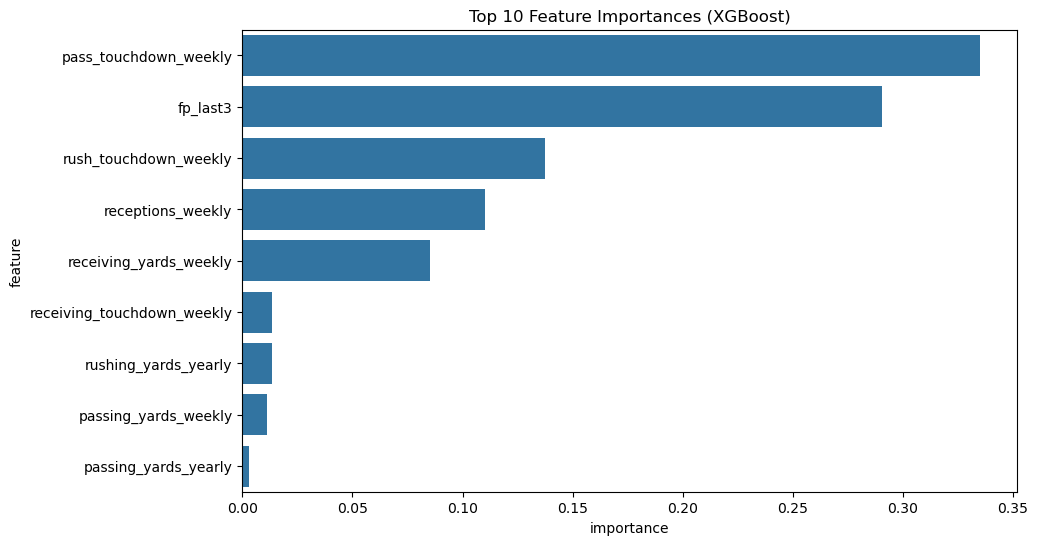

In [ ]:
# Feature importance
importances = xgb.feature_importances_
feat_importance = pd.DataFrame({
    'feature': features,  # your original feature list
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_importance.head(10))
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()


##### Advanced Regression / Prediction Models

In [13]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=23)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest r2:", r2_score(y_test,y_pred_rf))

Random Forest r2: 0.9546989326508935


In [14]:
xgb = XGBRegressor(n_estimators=100, 
                    learning_rate=0.05, 
                    max_depth=6, 
                    random_state=23)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
print('XGBoost R2:', r2_score(y_test, y_pred_xgb))


XGBoost R2: 0.9553527317733034


In [15]:
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

nn.compile(optimizer='adam', loss='mse')
nn.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_nn = nn.predict(X_test_scaled).flatten()
print("Neural Network R2:", r2_score(y_test, y_pred_nn))

c:\Users\omend\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Neural Network R2: 0.9586900645048108


In [ ]:
# Correlation heatmap for numeric features

numcols = [
 'passing_yards_weekly','pass_touchdown_weekly','rushing_yards_weekly','rush_touchdown_weekly',
 'receptions_weekly','receiving_yards_weekly','receiving_touchdown_weekly','fp_last3',
 'passing_yards_yearly','rushing_yards_yearly','fantasy_points_ppr_yearly'
]
subset = data_merged[[c for c in numcols if c in data_merged.columns]].dropna()
plt.figure(figsize=(10,8))
sns.heatmap(subset.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix (selected features)")
plt.show()


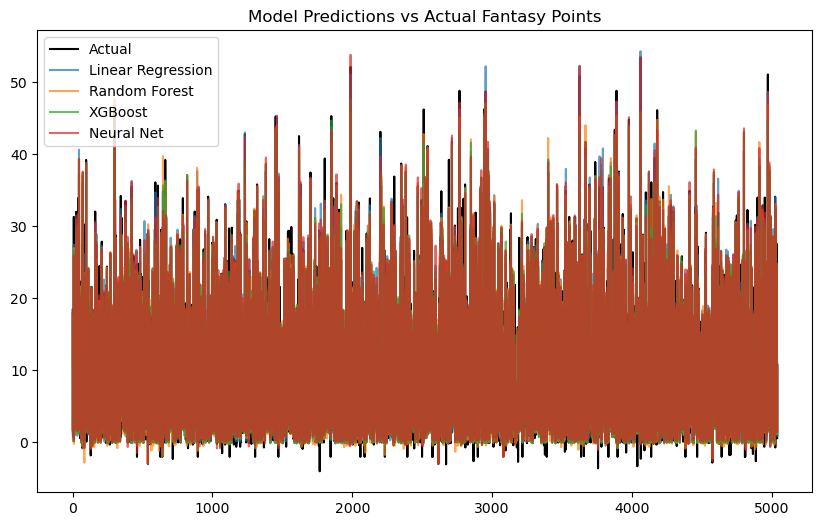

In [16]:
models = {
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "Neural Net": y_pred_nn
}

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="black")

for name, preds in models.items():
    plt.plot(preds, label=name, alpha=0.7)

plt.legend()
plt.title("Model Predictions vs Actual Fantasy Points")
plt.show()


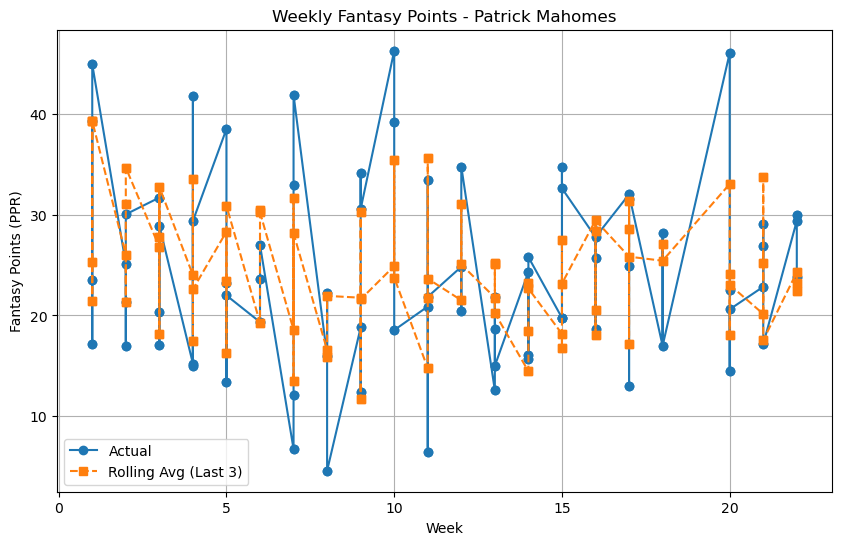

In [17]:
# --- Player Weekly Trend ---
player = "Patrick Mahomes"
df_player = data_merged[data_merged['player_name_weekly'] == player].sort_values("week")

plt.figure(figsize=(10,6))
plt.plot(df_player["week"], df_player["fantasy_points_ppr_weekly"], marker="o", label="Actual")
plt.plot(df_player["week"], df_player["fp_last3"], marker="s", linestyle="--", label="Rolling Avg (Last 3)")
plt.title(f"Weekly Fantasy Points - {player}")
plt.xlabel("Week")
plt.ylabel("Fantasy Points (PPR)")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

Next 3 weeks forecast for Patrick Mahomes: [22.70428567386528, 24.24031488756198, 24.504169288543967]


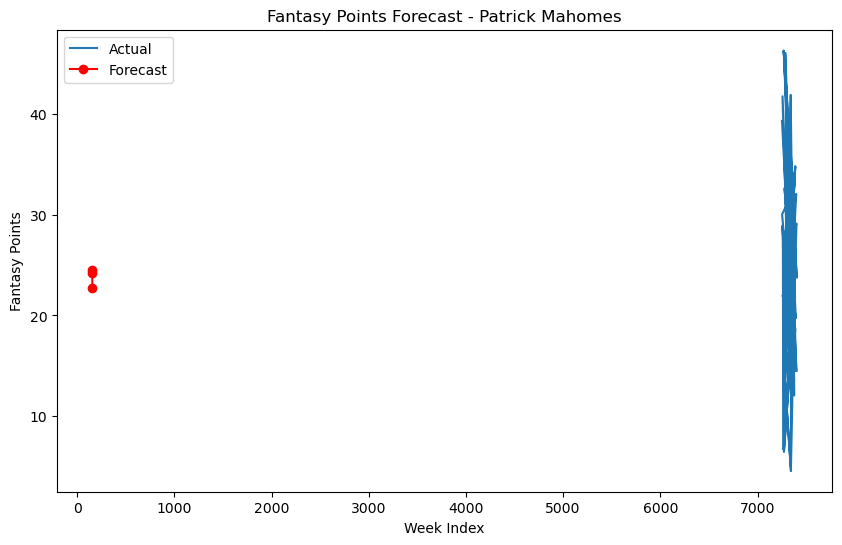

In [18]:
ts = df_player['fantasy_points_ppr_weekly']

# Fit ARIMA
model = ARIMA(ts, order=(2,1,2))  # tune p,d,q
model_fit = model.fit()

# Forecast next 3 weeks
forecast = model_fit.forecast(steps=3)
print(f"Next 3 weeks forecast for {player}: {forecast.tolist()}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(ts.index, ts, label="Actual")
plt.plot(range(len(ts), len(ts)+3), forecast, marker="o", label="Forecast", color="red")
plt.title(f"Fantasy Points Forecast - {player}")
plt.xlabel("Week Index")
plt.ylabel("Fantasy Points")
plt.legend()
plt.show()

In [19]:
df_model

,passing_yards_weekly,pass_touchdown_weekly,rush_touchdown_weekly,receptions_weekly,receiving_yards_weekly,receiving_touchdown_weekly,fp_last3,passing_yards_yearly,rushing_yards_yearly,fantasy_points_ppr_weekly
0,379.0,4.0,0.0,0.0,0.0,0.0,35.160000,329.0,0.0,35.16
1,379.0,4.0,0.0,0.0,0.0,0.0,35.160000,5316.0,81.0,35.16
2,276.0,5.0,0.0,0.0,0.0,0.0,36.900000,329.0,0.0,38.64
3,276.0,5.0,0.0,0.0,0.0,0.0,36.900000,5316.0,81.0,38.64
4,432.0,1.0,1.0,0.0,0.0,0.0,34.826667,329.0,0.0,30.68
...,...,...,...,...,...,...,...,...,...,...
25198,0.0,0.0,0.0,2.0,25.0,0.0,8.066667,0.0,291.0,10.70
25199,0.0,0.0,0.0,0.0,0.0,0.0,8.333333,0.0,291.0,1.80
25200,0.0,0.0,0.0,0.0,0.0,0.0,4.833333,0.0,291.0,2.00
25201,0.0,0.0,0.0,1.0,4.0,0.0,2.233333,0.0,291.0,2.90


In [24]:
data_merged.columns

Index(['player_id', 'player_name_weekly', 'season', 'week',
       'passing_yards_weekly', 'pass_touchdown_weekly', 'rushing_yards_weekly',
       'rush_touchdown_weekly', 'receptions_weekly', 'receiving_yards_weekly',
       'receiving_touchdown_weekly', 'fantasy_points_ppr_weekly', 'fp_last3',
       'player_name_yearly', 'passing_yards_yearly', 'pass_touchdown_yearly',
       'rushing_yards_yearly', 'rush_touchdown_yearly', 'receptions_yearly',
       'receiving_yards_yearly', 'receiving_touchdown_yearly',
       'fantasy_points_ppr_yearly'],
      dtype='object')

In [27]:
from statsmodels.tsa.stattools import adfuller

def forecast_player_arima(player_id, season, steps=3, order=(1,0,1)):
    dfp = data_merged[(data_merged['player_id']==player_id) & (data_merged['season']==season)].sort_values('week')
    ts = dfp['fantasy_points_ppr_yearly'].dropna()
    if len(ts) < 5:
        return None
    try:
        model = ARIMA(ts, order=order)
        fit = model.fit()
        fc = fit.forecast(steps=steps)
        return fc
    except Exception as e:
        print("ARIMA failed for", player_id, e)
        return None

# Example: forecast top player (choose a known id)
example_pid = data_merged['player_id'].iloc[0]
print("Forecast for player_id", example_pid, forecast_player_arima(example_pid, season=2024, steps=3))

#Visualization
# Plot actual and forecast (if returned)
fc = forecast_player_arima(example_pid, 2024, steps=3)
if fc is not None:
    dfp = data_merged[(data_merged['player_id']==example_pid) & (data_merged['season']==2024)].sort_values('week')
    plt.figure(figsize=(8,4))
    plt.plot(dfp['week'], dfp['fantasy_points_ppr'], label='actual')
    plt.plot(range(dfp['week'].max()+1, dfp['week'].max()+1+len(fc)), fc, marker='o', label='forecast')
    plt.legend(); plt.title("ARIMA forecast (player)"); plt.show()


Forecast for player_id 00-0019596 None


Hybrid Recommendation System (synthetic ratings + SVD + hybrid score)

The goal is to generate personlized recommended players (who to draft/start) by blending collaborative filtering (user taste / historical picks) and content/statistics-based predictions.

Symthetic ratings creation (if you don't have user data)

In [ ]:
# Build synthetic ratings from weekly fantasy points:
np.random.seed(3)
players = data_merged['player_id'].unique()
num_users = 50
user_ids = list(range(1, num_users + 1))

ratings = []

player_mean = data_merged.groupby('player_id')['fantasy_points_ppr'].mean().dropna()
for u in user_ids:
    sampled = np.random.choice(player_mean.index, size=25, replace=False)
    for pid in sampled:
        score = player_mean.loc[pid]
        #map score to 1-50 scale (clip)
        rating = float(np.clip(score*3, 1, 50))
        ratings.append([u, int(pid), rating])
        
df_ratings = pd.DataFrame(ratings, columns=['user_id','player_id','rating'])
print(f'Synthetic ratings: {df_ratings.shape}')
        

Train collaborative filtering (SVD)

In [ ]:
reader = Reader(rating_scale=(1,50))
data_cf = Dataset.load_from_df(df_ratings[['user_id','player_id','rating']], reader)
train_cf, test_cf = surprise_split(data_cf, test_size=0.2, random_state=42)
algo = SVD(n_factors=30, random_state=3)
algo.fit(train_cf)
predictions = algo.test(test_cf)
accuracy.rmse(predictions)

Hybrid scorer: blend CF & Stats model

In [ ]:
# Precompute a stats-based baseline: mean weekly fantasy points per player
player_stats_mean = data_merged.groupby('player_id')['fantasy_points_ppr'].mean() 

def hybrid_score(user_id, player_id, e_cf=0.7, w_stats=0.3):
    #CF Prediction
    try:
        pred_cf = algo.predict(user_id, player_id).est
    except:
        pred_cf = player_stats_mean.get(player_id, player_stats_mean.mean())
    pred_stats = player_stats_mean.get(player_id, player_stats_mean.mean())
    return w_cf*pred_cf + w_stats*(pred_stats*3) # scale stats to CF scale if needed

# Example: top 10 for user 1
user = 1
scores = [(pid, hybrid_score(user, pid)) for pid in players]
top10 = sorted(scores, key=lambda x: x[1], reverse=True)[:10]
top10

Visualizations

In [ ]:
top_df = pd.DataFrame(top10, columns=['player_id', 'hybrid_score']).merge(
    data_merged[['player_id', 'player_name']].drop_duplicates('player_id'),
    on='player_id', how='left'
)

sns.barplot(x='hybrid_score', y='player_name', data=top_df)
plt.title('Top 10 hybrid recommendations (user 1)')
plt.show()

9) Build a Draft Board and Simulate a 2025 Roster

    9a) Draft board using season projections

For draft prep we want season-level projections (projected total points) rather than weekly points.

Two options:

Sum weekly predictions across remaining weeks.

Or train on historical season totals as target and predict season totals for 2025.

In [ ]:
# Build season-level mean projection per player using XGBoost or season model
# Here, as a simple example, use historical yearly fantasy_fantasy_ppr_yearly
season_projections = yearly.groupby(['player_id','season'])['fantasy_points_ppr_yearly'].mean().reset_index()
latest_proj = season_projections[season_projections['season']==2024].copy().rename(columns={'fantasy_points_ppr_yearly':'proj_points'})


# 2) compute replacement-level at each position (12-team example)
# you need position info in yearly or weekly (yearly may contain)

pos_map = yearly.set_index('player_id')['position'].to_dict() if 'position' in yearly.columns else {}
latest_proj['position'] = latest_proj['player_id'].map(pos_map)
latest_proj = latest_proj.dropna(subset=['position'])

cutoffs = {'QB': 12, 'RB': 24, 'WR':36, 'TE':12}
vorp_list = []



9b) Simulate picking an optimized roster for 2025

Simplified integer programming (12-team, starting lineup example): choose a roster maximizing sum(proj_points) subject to constraints (1 QB, 2 RB, 2 WR, 1 TE, 1 FLEX(RB/WR/TE), bench size variable). For a single-team pick: